In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/brain_dead_emotion_detection.zip

In [ ]:
import keras
from keras.applications import ResNet50, VGG16

# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(182, 182, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = keras.Input(shape=(182, 182, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the end layers
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32,kernel_initializer='he_uniform')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

# Set the final layer with softmax activation function
output_ = keras.layers.Dense(4, activation='softmax')(x)

# Create the new model object
model = keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 182, 182, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 batch_normalization_8 (Batc  (None, 73728)            294912    
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                2359328   
                                                           

In [4]:
import numpy as np
import cv2
import glob
from sklearn.utils import shuffle

def get_samples(data_type):
    X = []
    Y = []

    angry = '/content/brain_dead_emotion_detection/' + data_type + '/angry/'
    sad = '/content/brain_dead_emotion_detection/' + data_type + '/sad/'
    happy = '/content/brain_dead_emotion_detection/' + data_type + '/happy/'
    neutral = '/content/brain_dead_emotion_detection/' + data_type + '/neutral/'

    paths = [angry, sad, happy, neutral]

    for i in range(4):
      for file in glob.glob(paths[i] + "*.png"):
        X.append(np.asarray(cv2.imread(file)))
        Y.append([1 if j is i else 0 for j in range(4)])

    X = np.array(X)
    Y = np.array(Y)

    X,Y = shuffle(X,Y)
    return X, Y

XTrain, YTrain = get_samples("Train")
XTest, YTest = get_samples("Test")

In [ ]:
model.fit(XTrain, YTrain, epochs=20, validation_data=(XTest, YTest))

Epoch 1/20
57/57 [==============================] - 12s 115ms/step - loss: 1.1098 - accuracy: 0.5298 - val_loss: 1.1061 - val_accuracy: 0.5827
Epoch 2/20
57/57 [==============================] - 5s 96ms/step - loss: 0.6849 - accuracy: 0.7967 - val_loss: 0.8454 - val_accuracy: 0.6612
Epoch 3/20
57/57 [==============================] - 5s 84ms/step - loss: 0.4912 - accuracy: 0.8691 - val_loss: 0.7870 - val_accuracy: 0.6992
Epoch 4/20
57/57 [==============================] - 5s 94ms/step - loss: 0.3688 - accuracy: 0.9238 - val_loss: 0.7674 - val_accuracy: 0.7046
Epoch 5/20
57/57 [==============================] - 5s 96ms/step - loss: 0.2812 - accuracy: 0.9436 - val_loss: 0.8047 - val_accuracy: 0.6667
Epoch 6/20
57/57 [==============================] - 5s 84ms/step - loss: 0.2227 - accuracy: 0.9602 - val_loss: 0.7656 - val_accuracy: 0.6965
Epoch 7/20
57/57 [==============================] - 5s 95ms/step - loss: 0.2089 - accuracy: 0.9619 - val_loss: 0.7540 - val_accuracy: 0.7182
Epoch 8/20


In [ ]:
import keras
model = keras.models.load_model('/content/drive/MyDrive/Resnet50/Brain Dead/model_3(best)')
model.summary()

In [ ]:
model.save('/content/drive/MyDrive/Resnet50/Brain Dead/model_3(best)')

In [5]:
model.evaluate(XTest, YTest)

12/12 [==============================] - 34s 3s/step - loss: 0.9258 - accuracy: 0.6992


[0.9258376359939575, 0.6991869807243347]

In [6]:
y_pred = model.predict(XTest)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(YTest, axis=1)

12/12 [==============================] - 32s 3s/step


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['angry', 'sad', 'happy', 'neutral']
print("CLASSIFICATION REPORT:\n\n", classification_report(y_true, y_pred_classes, target_names=class_names))

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("\nCONFUSION MATRIX:\n\n", confusion_mtx)

CLASSIFICATION REPORT:

               precision    recall  f1-score   support

       angry       0.76      0.62      0.68        80
         sad       0.68      0.73      0.71        82
       happy       0.68      0.75      0.71       105
     neutral       0.70      0.68      0.69       102

    accuracy                           0.70       369
   macro avg       0.70      0.70      0.70       369
weighted avg       0.70      0.70      0.70       369


CONFUSION MATRIX:

 [[50 18  6  6]
 [13 60  6  3]
 [ 0  6 79 20]
 [ 3  4 26 69]]


ROC CURVES AND AUC SCORES FOR EACH CLASS:




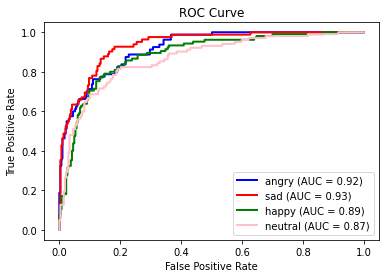

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convert true labels to binary form
y_true_binary = label_binarize(y_true, classes=[0,1,2,3])

# Calculate ROC curves and AUC scores for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green', 'pink']
class_names = ['angry', 'sad', 'happy', 'neutral']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Display the plot
print("ROC CURVES AND AUC SCORES FOR EACH CLASS:\n\n")
plt.show()